### Step 0: Load Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

### Step 1: Data Loading and Preprocessing

In [2]:
train_data=pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv',sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
train_data.head(2)

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057


In [4]:
train_data=train_data[['Uniq Id','Product Id','Product Rating','Product Reviews Count','Product Category', 'Product Brand', 'Product Name','Product Image Url','Product Description','Product Tags']]
train_data.head(2)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."


### Basic Operations

In [5]:
train_data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [6]:
train_data.shape

(5000, 10)

In [7]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [8]:
# Filling Null
train_data['Product Rating'].fillna(0,inplace=True)
train_data['Product Reviews Count'].fillna(0,inplace=True)
train_data['Product Category'].fillna('',inplace=True)
train_data['Product Brand'].fillna('',inplace=True)
train_data['Product Description'].fillna('',inplace=True)

In [9]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [10]:
# Duplicate Value
train_data.duplicated().sum()

0

In [11]:
train_data.columns

Index(['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count',
       'Product Category', 'Product Brand', 'Product Name',
       'Product Image Url', 'Product Description', 'Product Tags'],
      dtype='object')

In [12]:
# Make a column shorter
# Define thr mapping of current column names to shorter names 

column_name_mapping ={
    'Uniq Id': 'Id',
    'Product Id':'ProdID',
    'Product Rating':'Rating',
    'Product Reviews Count':'ReviewCount',
    'Product Category':'Category',
    'Product Brand':'Brand',
    'Product Name':'Name',
    'Product Image Url':'ImageURL',
    'Product Description':'Description',
    'Product Tags':'Tags',
    'Product Contents':'Contents'
}
# Rename the column using the mapping 
train_data.rename(columns=column_name_mapping, inplace=True)

In [13]:
train_data.head()

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [14]:
train_data['Id']=train_data['Id'].str.extract(r'(\d+)').astype(float)
train_data['ProdID']=train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [15]:
train_data

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


### Step 2: EDA (Exploratory Data Analysis)

In [16]:
# Basic Statistics

num_users=train_data['Id'].nunique()
num_items=train_data['ProdID'].nunique()
num_ratings=train_data['Rating'].nunique()
print(f'Number of unique users: {num_users}')
print(f'Number of unique items: {num_items}')
print(f'Number of unique ratings: {num_ratings}')

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


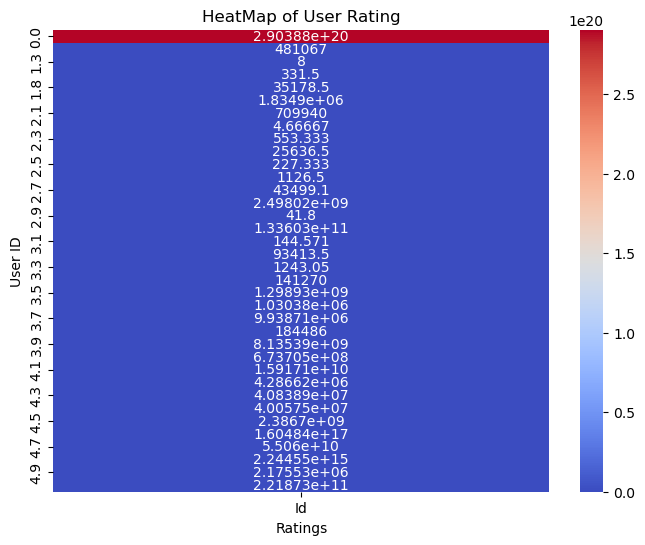

In [17]:
# Pivot the DataFrame to create HeatMap
heatmap_data=train_data.pivot_table('Id','Rating')

# Create a HeatMap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data,annot=True,fmt='g',cmap='coolwarm',cbar=True)
plt.title('HeatMap of User Rating')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

Text(0.5, 1.0, 'Most Popular Items')

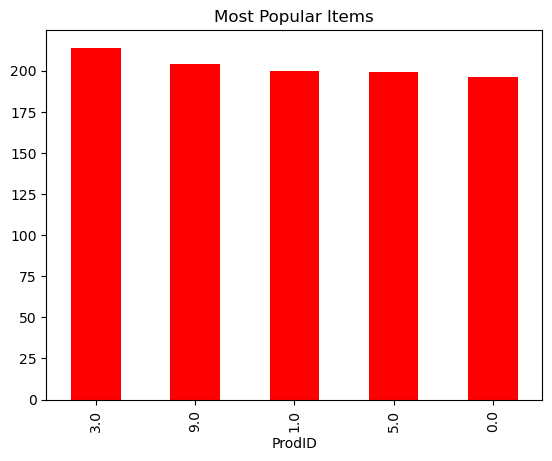

In [18]:
# Most popular Item

popular_items= train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title('Most Popular Items')

<Axes: xlabel='Rating'>

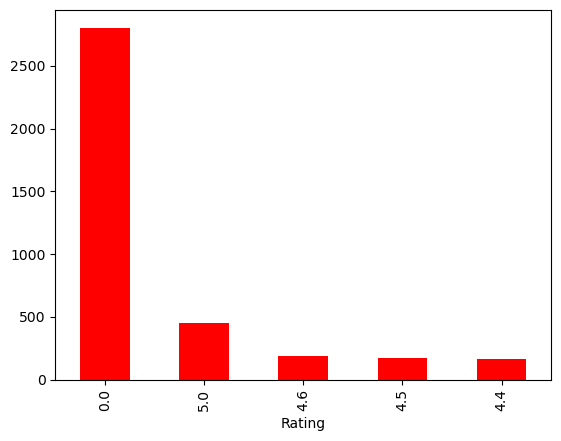

In [19]:
# Most rated counts
train_data['Rating'].value_counts().head(5).plot(kind='bar',color='red')

### Step 3: Data Cleaning and Tag Creations

In [20]:
train_data['Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Tags, Length: 5000, dtype: object

In [21]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 

nlp=spacy.load('en_core_web_sm')

def clean_and_extract_tags(text):
    doc=nlp(text.lower())
    tags=[token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from=['Category','Brand','Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [22]:
train_data

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...",Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,"household, essentials, air, fresheners, spray,...","eclectic, lady","Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"garden, mint, lovely, blend, spearmint, lettuc...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0.000000e+00,1.0,3.9,7484.0,"beauty, hair, care, hair, color, permanent, ha...",garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,"garnier, nutrisse, nourishing, hair, color, cr...",Garnier Nutrisse Nourishing Hair Color Creme (...
4997,3.400000e+01,96.0,0.0,4.0,"beauty, makeup, nails",stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,"multifunctional, nail, drill, kit, come, 6, di...","Nail File Electric Drill, 6 in 1 Professional ..."
4998,9.000000e+00,7.0,0.0,0.0,"premium, beauty, premium, bath, body, premium,...",creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [23]:
# Concatenate the cleaned tagsfrom all relevant columns 

train_data['Tags']=train_data[columns_to_extract_tags_from].apply(lambda row:', '.join(row),axis=1)

### Rating Base Recommendation System

In [24]:
train_data.head(2)

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."


In [25]:
average_ratings=train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [26]:
top_rated_items=average_ratings.sort_values(by='Rating',ascending=False)
rating_base_recommendation=top_rated_items.head(10)

In [27]:
rating_base_recommendation['Rating']=rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount']=rating_base_recommendation['ReviewCount'].astype(int)

C:\Users\PushkarJaiswal\AppData\Local\Temp\ipykernel_15124\2996061302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating']=rating_base_recommendation['Rating'].astype(int)
C:\Users\PushkarJaiswal\AppData\Local\Temp\ipykernel_15124\2996061302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount']=rating_base_recommendation['ReviewCount'].astype(int)


In [28]:
rating_base_recommendation

,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,"gold, bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,"red, devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,"air, wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,"long, aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


### Content Base Recommendation System (User Preferences or Items Similarities)

In [29]:
train_data.head(1)

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer=TfidfVectorizer(stop_words='english')
tfidf_matrix_content=tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarity_content=cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [31]:
cosine_similarity_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [32]:
train_data['Name'][0]

'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

In [33]:
Item_name='OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
Item_index=train_data[train_data['Name']==Item_name].index[0]


In [34]:
similar_items=list(enumerate(cosine_similarity_content[Item_index]))
similar_items

[(0, 1.0),
 (1, 0.0034757732312750934),
 (2, 0.003632261383918426),
 (3, 0.013151377769582695),
 (4, 0.0010160210269512565),
 (5, 0.006575809352364544),
 (6, 0.007328463323503305),
 (7, 0.05151153351231972),
 (8, 0.011109860476686882),
 (9, 0.003151730172379002),
 (10, 0.0),
 (11, 0.1587457628497677),
 (12, 0.04098008361044332),
 (13, 0.0030468898686792107),
 (14, 0.0),
 (15, 0.0059693458494800575),
 (16, 0.3398806576145607),
 (17, 0.0),
 (18, 0.004556103655641239),
 (19, 0.0038887588090144405),
 (20, 0.008764149884645193),
 (21, 0.0),
 (22, 0.009458897953602717),
 (23, 0.0),
 (24, 0.00517558550504985),
 (25, 0.0),
 (26, 0.007172857177991527),
 (27, 0.003259884833851906),
 (28, 0.2812052802661157),
 (29, 0.0),
 (30, 0.007207084216281134),
 (31, 0.006229511383962109),
 (32, 0.008773214115073319),
 (33, 0.010764957375515107),
 (34, 0.005638510010303099),
 (35, 0.01026020396150954),
 (36, 0.0020164119152476824),
 (37, 0.0032782013683666338),
 (38, 0.005164021192923341),
 (39, 0.0),
 (40, 

In [35]:
similar_items=sorted(similar_items, key=lambda x:x[1],reverse=True)
top_similar_items=similar_items[1:10]


In [36]:
top_similar_items

[(156, 1.0),
 (184, 1.0),
 (205, 1.0),
 (237, 1.0),
 (325, 1.0),
 (375, 1.0),
 (402, 1.0),
 (706, 1.0),
 (886, 1.0)]

In [37]:
recommended_item_indics=[x[0] for x in top_similar_items]
recommended_item_indics

[156, 184, 205, 237, 325, 375, 402, 706, 886]

In [38]:
train_data.iloc[recommended_item_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


### Function To Recommend Products for Content Base


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [40]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [41]:
train_data['Name'][4]

'Gillette TRAC II Plus Razor Blade Refills, Fit TRAC II Handles, 10 ct'

In [42]:
# Example: Get content-based recommendations for a specific item
item_name = 'Gillette TRAC II Plus Razor Blade Refills, Fit TRAC II Handles, 10 ct'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
752,Gillette Trac II Plus Refill Razor Blade Cartr...,16.0,gillette,https://i5.walmartimages.com/asr/d19864e6-f6ac...,0.0
4911,Gillette SkinGuard Sensitive Razor for Men Ref...,0.0,gillette,https://i5.walmartimages.com/asr/0d2dcf60-0710...,0.0
1155,Gillette Daisy Classic Disposable Womens Razor...,8.0,gillette,https://i5.walmartimages.com/asr/f90b7290-c3b2...,0.0
2895,Gillette Platinum Double Edge Blades,0.0,gillette,https://i5.walmartimages.com/asr/eb71a697-1bd3...,0.0
889,Gillette Venus Embrace Sensitive Womens Razor ...,955.0,gillette,https://i5.walmartimages.com/asr/38a4395a-60a1...,4.6
3884,"BIC Sensitive Shaver Mens Disposable Razor, Si...",219.0,bic,https://i5.walmartimages.com/asr/7d961553-5f95...,0.0
2084,Harrys Mens Razor: Bright Orange Handle and 2 ...,538.0,harry,https://i5.walmartimages.com/asr/a9fad72b-91a1...,0.0
1000,Gillette Series Cool Wave Mens Aftershave Spla...,136.0,gillette,https://i5.walmartimages.com/asr/7556a516-c2f7...,0.0


In [43]:
train_data['Name'][5]

'Old Spice Artisan Styling High Hold Matte Finish Molding Clay, 2.64 oz'

In [44]:
# Example: Get content-based recommendations for a specific item
item_name = 'Old Spice Artisan Styling High Hold Matte Finish Molding Clay, 2.64 oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
339,Old Spice Wild Collection Bearglove Mens Deodo...,19.0,"old, spice",https://i5.walmartimages.com/asr/be1a76a3-88a6...,4.2
1934,Old Spice Fresher Collection Deep Sea Invisibl...,256.0,"old, spice",https://i5.walmartimages.com/asr/137049af-32ee...,4.4
1554,"Old Spice Ultra Smooth Deodorant, Fresh Start,...",504.0,"old, spice",https://i5.walmartimages.com/asr/1dea23e2-1122...,4.7
3725,Old Spice High Endurance Original Anti-Perspir...,92.0,"old, spice",https://i5.walmartimages.com/asr/a0a4af40-75b3...,3.7
1282,"($25 Value) Old Spice Hair and Body Gift Set, ...",24.0,"old, spice",https://i5.walmartimages.com/asr/14191050-a3b2...,0.0
2252,Old Spice Antiperspirant and Deodorant Invisib...,20.0,"old, spice",https://i5.walmartimages.com/asr/49b8ce0f-28f7...,0.0
552,(6 pack) Old Spice Classic Original Deodorant ...,352.0,"old, spice",https://i5.walmartimages.com/asr/fa4947ea-dffc...,0.0
477,Old Spice Yetifrost Scent Body Wash with Cooli...,78.0,"old, spice",https://i5.walmartimages.com/asr/1b3690d8-f731...,0.0


### Collabrative Filtering (User Item Similarity)

In [45]:
user_item_matrix=train_data.pivot_table(index='Id',columns='ProdID',values='Rating',aggfunc='mean').fillna(0).astype(int)
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
Id,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.000000e+00,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.007694e+17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
user_similarity=cosine_similarity(user_item_matrix)
user_similarity

array([[1.        , 0.08328508, 0.08776176, ..., 0.        , 0.03388371,
        0.        ],
       [0.08328508, 1.        , 0.09334828, ..., 0.        , 0.        ,
        0.        ],
       [0.08776176, 0.09334828, 1.        , ..., 0.        , 0.0417756 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.03388371, 0.        , 0.0417756 , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
target_user_id=4
target_user_index=user_item_matrix.index.get_loc(target_user_id)
target_user_index

4

In [48]:
user_similarities=user_similarity[target_user_index]
user_similarities

array([0.0675362 , 0.0920999 , 0.044717  , ..., 0.        , 0.03691067,
       0.        ])

In [49]:
similar_user_indices=user_similarities.argsort()[::-1][1:]
similar_user_indices

array([  84, 1552,  702, ..., 1104, 1105,  860], dtype=int64)

In [50]:
recommend_items=[]
for user_index in similar_user_indices:
    rated_by_similar_user=user_item_matrix.iloc[user_index]
    not_rated_by_target_user=(rated_by_similar_user)&(user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommend_items

[107021.0,
 22.0,
 22.0,
 61.0,
 101.0,
 124.0,
 231.0,
 318.0,
 850.0,
 900.0,
 4158.0,
 7520.0,
 22.0,
 37.0,
 73.0,
 98.0,
 655.0,
 944.0,
 4759.0,
 4879.0,
 6468.0,
 36089.0,
 12242.0,
 1.0,
 10.0,
 21.0,
 27.0,
 110.0,
 499.0,
 517.0,
 885.0,
 1680.0,
 190182.0,
 7092.0,
 512.0,
 870.0,
 25.0,
 1.0,
 32.0,
 233.0,
 1.0,
 6.0,
 36.0,
 47.0,
 82.0,
 85.0,
 309.0,
 424.0,
 569.0,
 705.0,
 95.0,
 6.0,
 25.0,
 28.0,
 31.0,
 33.0,
 40.0,
 63.0,
 72.0,
 81.0,
 91.0,
 98.0,
 35340.0,
 46.0,
 6.0,
 56.0,
 59.0,
 71.0,
 82.0,
 87.0,
 98.0,
 99.0,
 407.0,
 608.0,
 1.0,
 11.0,
 22.0,
 38.0,
 54.0,
 238.0,
 273.0,
 451.0,
 2975.0,
 5007.0,
 850.0,
 31305.0,
 28.0,
 464.0,
 5012443.0,
 8.7300560113794e+39,
 66.0,
 930.0,
 586847.0,
 362845370405.0,
 711.0,
 1675.0,
 46.0,
 471.0,
 61.0,
 12.0,
 470.0,
 19114.0,
 1337643.0,
 179.0,
 71114.0,
 1.0,
 11.0,
 31.0,
 37.0,
 60.0,
 89.0,
 185.0,
 226.0,
 289.0,
 358.0,
 71.0,
 2261.0,
 89666743.0,
 375231077.0,
 41.0,
 4489.0,
 15.0,
 611.0,
 510.0,
 

In [51]:
train_data[train_data['ProdID'].isin(recommend_items)]

,Id,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
1,95.0,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
10,819345.0,54.0,0.0,0.0,"seasonal, minute, gifts","art, shaving","The Art of Shaving Mens Hair Styling Gel, Juni...",https://i5.walmartimages.com/asr/661839a6-67ac...,"art, shaving, forming, paste, infused, juniper...","seasonal, minute, gifts, art, shaving, art, sh..."
12,39521.0,5956.0,3.8,184.0,"beauty, makeup, face, makeup, face, primer",paris,"LOreal Paris True Match Super-Blendable Blush,...",https://i5.walmartimages.com/asr/506a78ca-cca6...,"true, match, blush, flawlessly, complements, s...","beauty, makeup, face, makeup, face, primer, pa..."
15,35.0,1.0,3.7,2935.0,"beauty, hair, care, hair, color, auburn, hair,...",clairol,Clairol Natural Instincts Demi-Permanent Hair ...,https://i5.walmartimages.com/asr/00a6e54a-e431...,"discover, natural, way, shine, 80, naturally, ...","beauty, hair, care, hair, color, auburn, hair,..."
21,11261.0,358.0,0.0,39.0,"patio, garden, garden, center, insect, pest, c...",terro,TERRO Outdoor Liquid Ant Baits - 6 Traps,https://i5.walmartimages.com/asr/2921aa69-a940...,"terro, outdoor, liquid, ant, baits, ideal, lar...","patio, garden, garden, center, insect, pest, c..."
...,...,...,...,...,...,...,...,...,...,...
4990,0.0,1.0,4.7,43.0,"personal, care, personal, care, brand, crest",crest,2 Pack - Crest 3D White Brilliance Fluoride An...,https://i5.walmartimages.com/asr/5758fbaf-5515...,"pack, 2, upc, 037000943822, product, descripti...","personal, care, personal, care, brand, crest, ..."
4994,5.0,87.0,0.0,0.0,"premium, beauty, premium, facial, skincare, pr...",sekkisei,"Sekkisei Herbal Gel, 2.8 oz (79 ml)",https://i5.walmartimages.com/asr/38a0829f-0000...,,"premium, beauty, premium, facial, skincare, pr..."
4996,0.0,1.0,3.9,7484.0,"beauty, hair, care, hair, color, permanent, ha...",garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,"garnier, nutrisse, nourishing, hair, color, cr...","beauty, hair, care, hair, color, permanent, ha..."
4997,34.0,96.0,0.0,4.0,"beauty, makeup, nails",stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,"multifunctional, nail, drill, kit, come, 6, di...","beauty, makeup, nails, stoneway, multifunction..."


In [52]:
recommended_items_details=train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]
recommended_items_details

,Name,ReviewCount,Brand,ImageURL,Rating
1,"Nice n Easy Permanent Color, 111 Natural Mediu...",0.0,easy,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,0.0
10,"The Art of Shaving Mens Hair Styling Gel, Juni...",0.0,"art, shaving",https://i5.walmartimages.com/asr/661839a6-67ac...,0.0
12,"LOreal Paris True Match Super-Blendable Blush,...",184.0,paris,https://i5.walmartimages.com/asr/506a78ca-cca6...,3.8
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
21,TERRO Outdoor Liquid Ant Baits - 6 Traps,39.0,terro,https://i5.walmartimages.com/asr/2921aa69-a940...,0.0
...,...,...,...,...,...
4990,2 Pack - Crest 3D White Brilliance Fluoride An...,43.0,crest,https://i5.walmartimages.com/asr/5758fbaf-5515...,4.7
4994,"Sekkisei Herbal Gel, 2.8 oz (79 ml)",0.0,sekkisei,https://i5.walmartimages.com/asr/38a0829f-0000...,0.0
4996,Garnier Nutrisse Nourishing Hair Color Creme (...,7484.0,garnier,https://i5.walmartimages.com/asr/24d7a837-51f8...,3.9
4997,"Nail File Electric Drill, 6 in 1 Professional ...",4.0,stoneway,https://i5.walmartimages.com/asr/d6202179-2c93...,0.0


### Function That Recommend Item

In [53]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='Id', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)


In [54]:
# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec    

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


### Hybrid Recommendation

In [55]:
 # Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [56]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [57]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
